In [27]:
import pandas as pd
import numpy as np
from scipy.stats import boxcox

from statsmodels.tsa.seasonal import STL
import matplotlib.dates as mdates




In [2]:
combined_recession_df = pd.read_csv('../data/combined/recession_probability.csv')
processed_recession_df = pd.read_csv('../data/processed/recession_probability.csv')

In [3]:
combined_recession_df.shape

(700, 20)

In [4]:
processed_recession_df.shape

(700, 18)

In [5]:
combined_recession_df.columns

Index(['date', 'recession_probability', '1_month_recession_probability',
       '3_month_recession_probability', '6_month_recession_probability',
       '1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO',
       '10_year_rate', 'share_price', 'unemployment_rate', 'PPI',
       'OECD_CLI_index', 'CSI_index', 'Business_Quarter', 'Month', 'Country',
       'gdp_per_capita'],
      dtype='object')

In [10]:
processed_recession_df['date'] = combined_recession_df['date']

# Export updated processed_recession_df to CSV
processed_recession_df.to_csv("../data/processed/recession_probability.csv", index=False)

print(f"Column '{'date'}' added and file saved as processed_recession_updated.csv")

Column 'date' added and file saved as processed_recession_updated.csv


In [11]:
processed_recession_df.columns

Index(['recession_probability', '1_month_recession_probability',
       '3_month_recession_probability', '6_month_recession_probability',
       '1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO',
       '10_year_rate', 'share_price', 'unemployment_rate', 'PPI',
       'OECD_CLI_index', 'CSI_index', 'Year', 'Quarter_Number', 'Month_Number',
       'date'],
      dtype='object')

In [12]:
gdp_monthly_df = pd.read_csv("../data/raw/processed/interpolated-processed-A939RX0Q048SBEA.csv")

# Ensure both are datetime
processed_recession_df['date'] = pd.to_datetime(processed_recession_df['date'])
gdp_monthly_df['date'] = pd.to_datetime(gdp_monthly_df['date'])

# Merge
merged_df = processed_recession_df.merge(gdp_monthly_df, on="date", how="left")

# Save
merged_df.to_csv("../data/processed/recession_probability.csv", index=False)


In [15]:
processed_recession_df = pd.read_csv("../data/processed/recession_probability.csv")

# Columns present in combined_recession_df but not in processed_recession_df
diff1 = set(combined_recession_df.columns) - set(processed_recession_df.columns)

# Columns present in processed_recession_df but not in combined_recession_df
diff2 = set(processed_recession_df.columns) - set(combined_recession_df.columns)

print("In combined_recession_df but not in processed_recession_df:", diff1)
print("In processed_recession_df but not in combined_recession_df:", diff2)


In combined_recession_df but not in processed_recession_df: {'Month', 'Business_Quarter', 'Country'}
In processed_recession_df but not in combined_recession_df: {'Year', 'Month_Number', 'Quarter_Number'}


In [16]:
processed_recession_df.shape

(700, 20)

In [18]:
# Ensure no non-positive values before Box-Cox
share_price = processed_recession_df['share_price']
shift_value = 0
if (share_price <= 0).any():
    shift_value = abs(share_price.min()) + 1
    share_price = share_price + shift_value

# Apply Box-Cox transformation
share_price_boxcox, lambda_bc = boxcox(share_price)

# Replace original column with transformed values
processed_recession_df['share_price'] = share_price_boxcox

print(f"Box-Cox λ (lambda) for share_price: {lambda_bc:.4f}")
if shift_value > 0:
    print(f"Note: Data was shifted by {shift_value} before transformation.")

# Export to CSV
processed_recession_df.to_csv("../data/processed/recession_probability.csv", index=False)
print("File saved to ../data/processed/recession_probability.csv")

Box-Cox λ (lambda) for share_price: 0.1137
File saved to ../data/processed/recession_probability.csv


In [19]:
processed_recession_df = pd.read_csv("../data/processed/recession_probability.csv")



In [20]:
processed_recession_df.columns

Index(['recession_probability', '1_month_recession_probability',
       '3_month_recession_probability', '6_month_recession_probability',
       '1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO',
       '10_year_rate', 'share_price', 'unemployment_rate', 'PPI',
       'OECD_CLI_index', 'CSI_index', 'Year', 'Quarter_Number', 'Month_Number',
       'date', 'gdp_per_capita'],
      dtype='object')

In [ ]:
import pandas as pd

# Make sure date column is datetime
processed_recession_df['date'] = pd.to_datetime(processed_recession_df['date'])
processed_recession_df = processed_recession_df.sort_values('date')

# Set seasonal period (12 for monthly data)
seasonal_period = 12

# Columns to decompose
cols_to_decompose = ['gdp_per_capita', 'share_price', 'CPI', 'INDPRO', 'unemployment_rate']

for col in cols_to_decompose:
    print(f"Decomposing {col}...")
    series = processed_recession_df.set_index('date')[col]
    
    # Drop NaNs for STL
    series = series.dropna()
    
    stl = STL(series, period=seasonal_period, robust=True)
    result = stl.fit()
    
    # Map back to the original dataframe
    processed_recession_df.loc[series.index, f"{col}_trend"] = result.trend
    processed_recession_df.loc[series.index, f"{col}_residual"] = result.resid

# Export updated dataset
processed_recession_df.to_csv("../data/combined/processed_recession_with_stl.csv", index=False)

print("✅ STL decomposition done and file exported.")


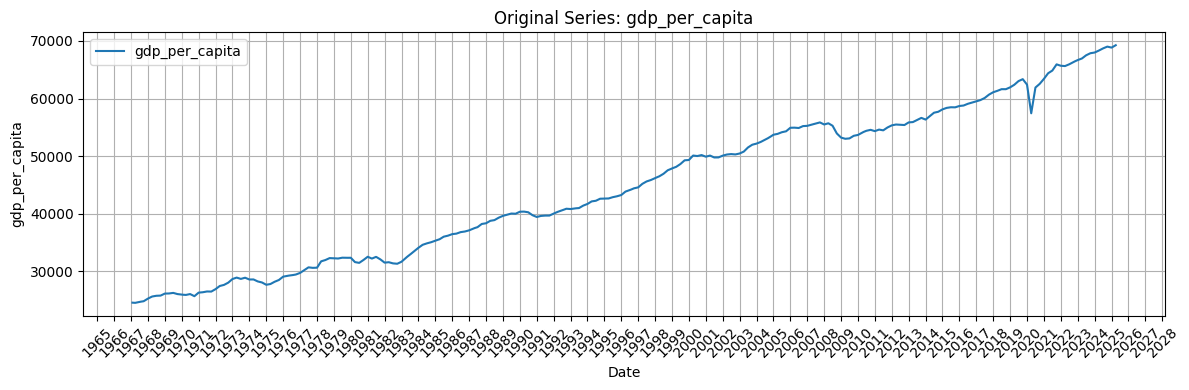

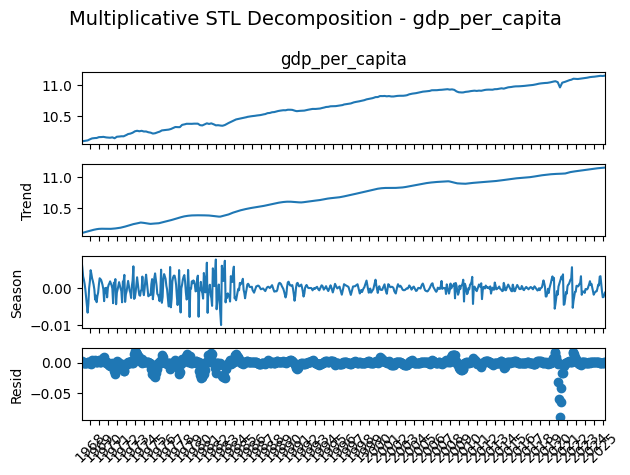

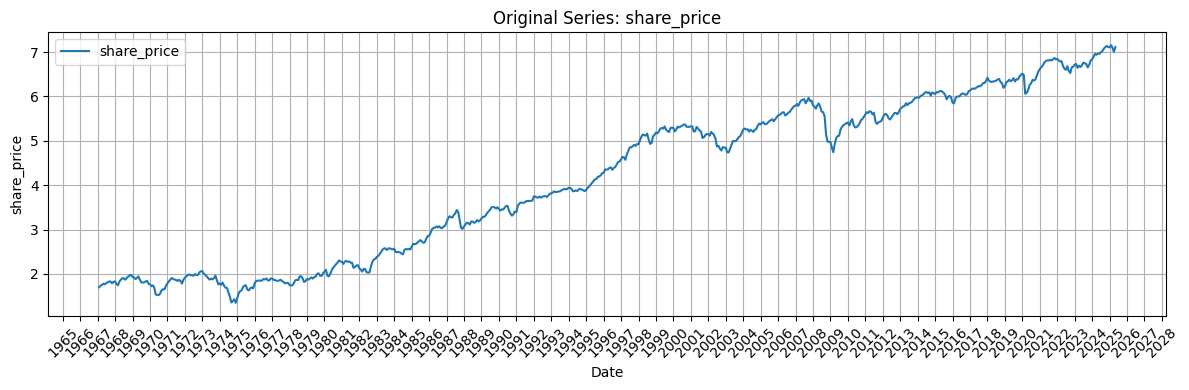

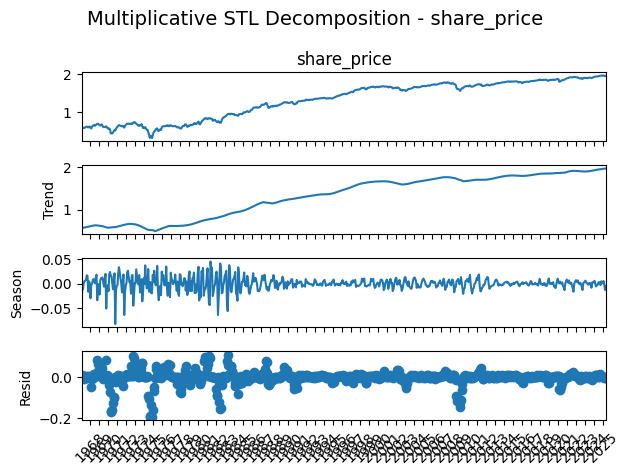

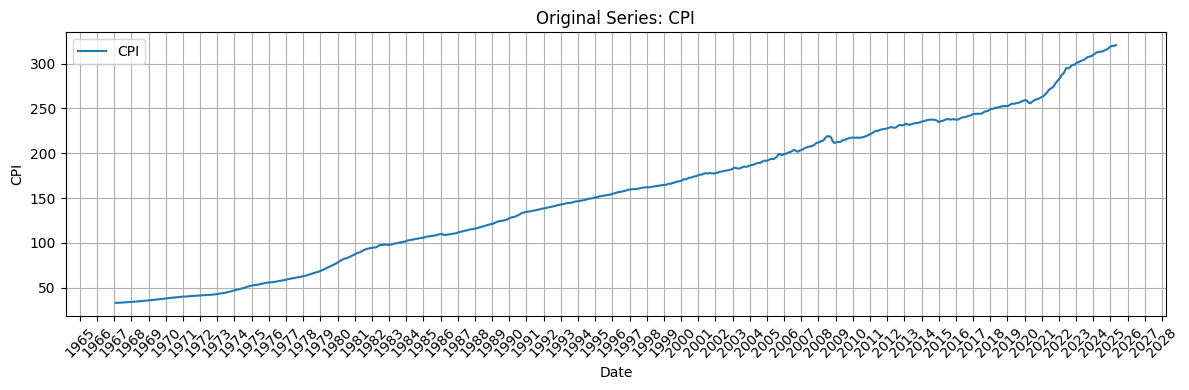

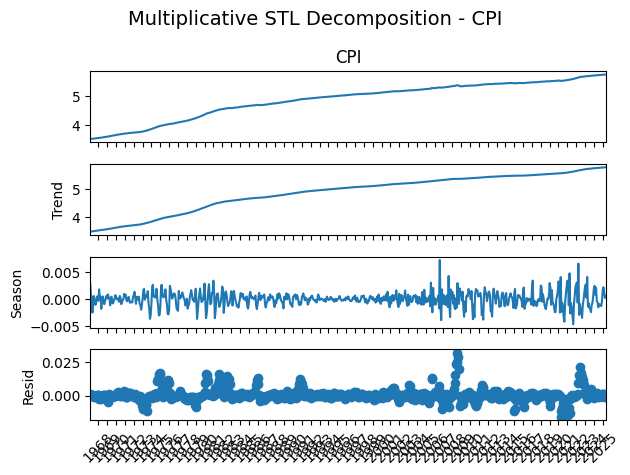

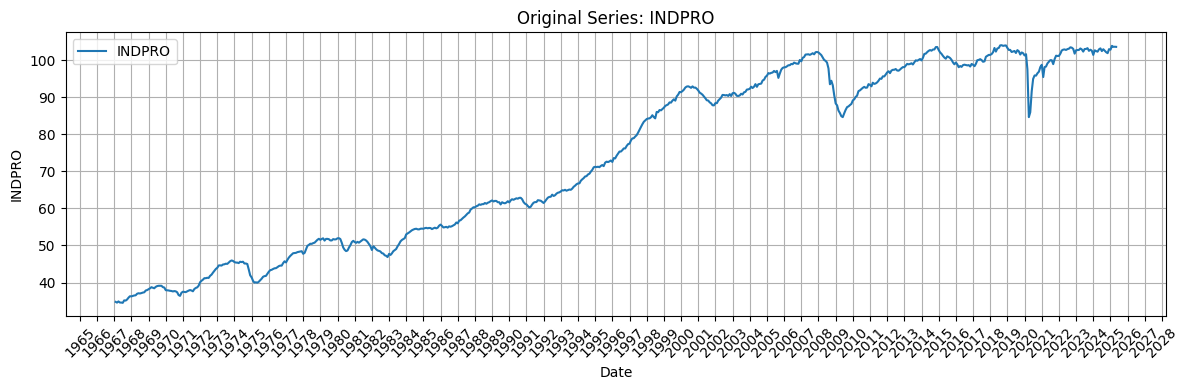

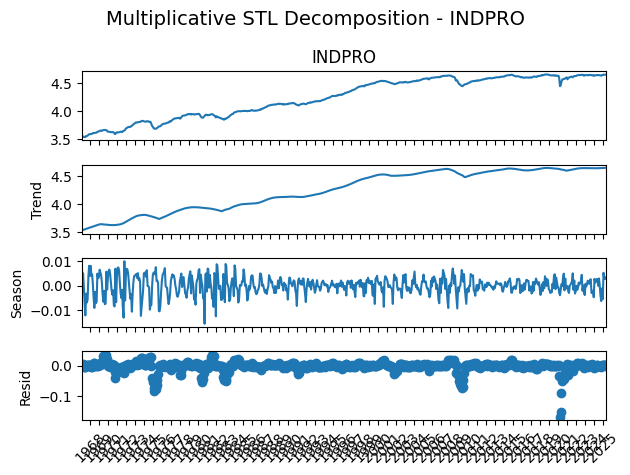

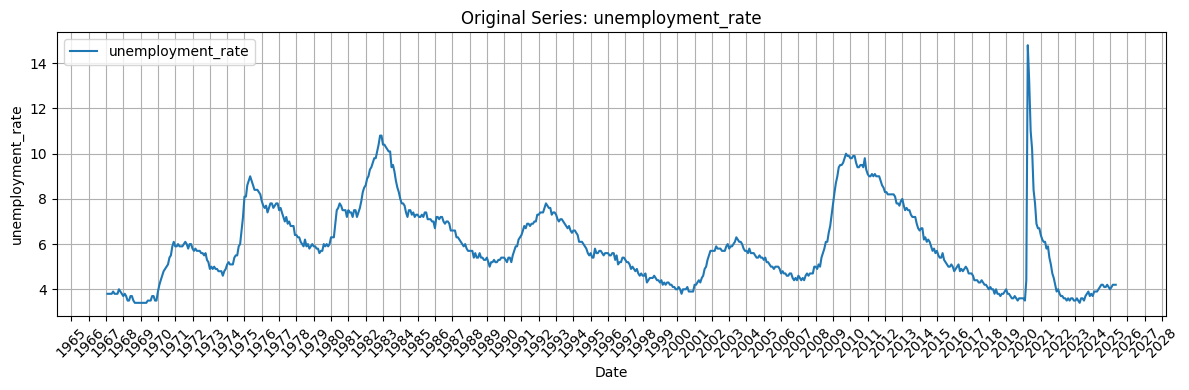

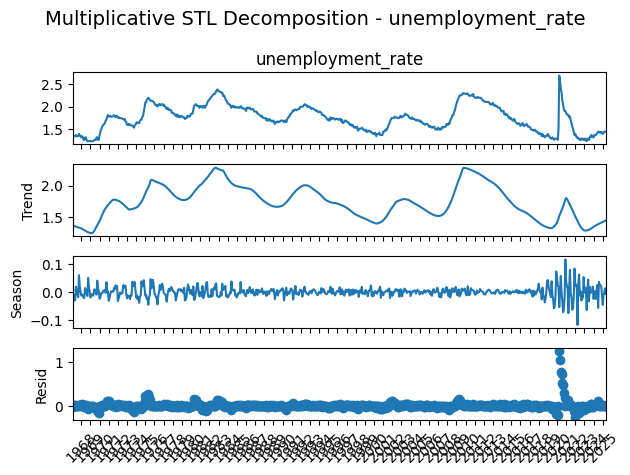

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

# Load your data
df = processed_recession_df.copy()  # Assuming recession_df is already loaded with a 'date' column
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

# Columns to decompose
cols_to_decompose = ['gdp_per_capita', 'share_price', 'CPI', 'INDPRO', 'unemployment_rate']

# Function to perform multiplicative STL decomposition
def multiplicative_stl(series, period=12):
    """Apply multiplicative STL decomposition."""
    # Log transform to handle multiplicative effects
    series_logged = np.log(series.replace(0, np.nan)).dropna()
    
    stl = STL(series_logged, period=period, robust=True)
    result = stl.fit()
    
    # Reverse log transform for plotting (optional)
    trend = np.exp(result.trend)
    seasonal = np.exp(result.seasonal)
    resid = np.exp(result.resid)
    
    return result, trend, seasonal, resid

# Loop through each column
for col in cols_to_decompose:
    plt.figure(figsize=(12, 4))
    plt.plot(df.index, df[col], label=col)
    plt.title(f"Original Series: {col}")
    plt.xlabel("Date")
    plt.ylabel(col)
    plt.legend()
    plt.grid(True)

    # Set major ticks to yearly interval
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    # Format ticks as year only
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    plt.xticks(rotation=45)  # Optional: rotate year labels for better visibility
    plt.tight_layout()
    plt.show()

    # Perform multiplicative STL decomposition
    result, trend, seasonal, resid = multiplicative_stl(df[col])

    # Plot decomposition results
    fig = result.plot()

    # Also adjust x-axis here
    ax = fig.axes[0]
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    for axis in fig.axes:
        for label in axis.get_xticklabels():
            label.set_rotation(45)

    fig.suptitle(f"Multiplicative STL Decomposition - {col}", fontsize=14)
    plt.tight_layout()
    plt.show()


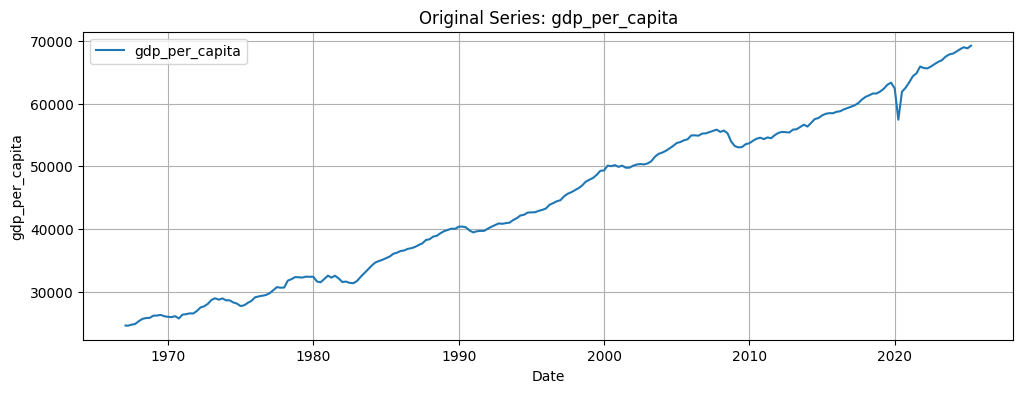

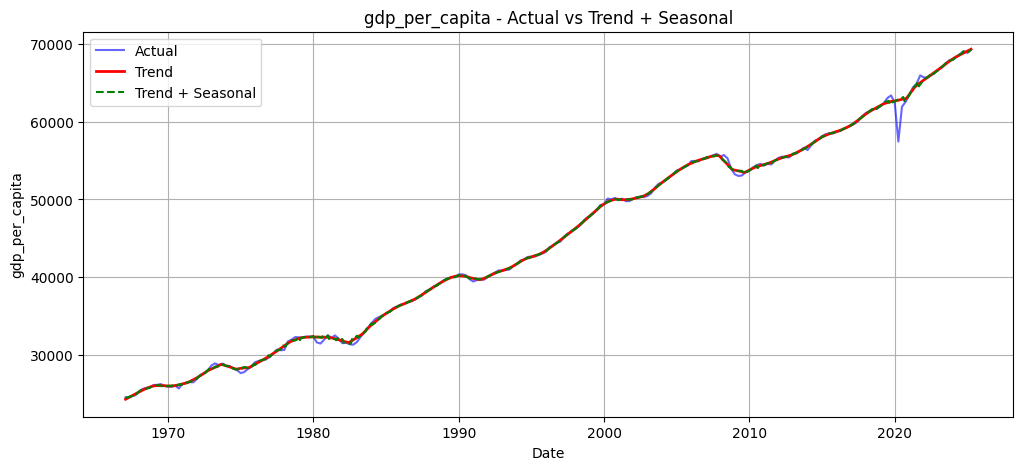

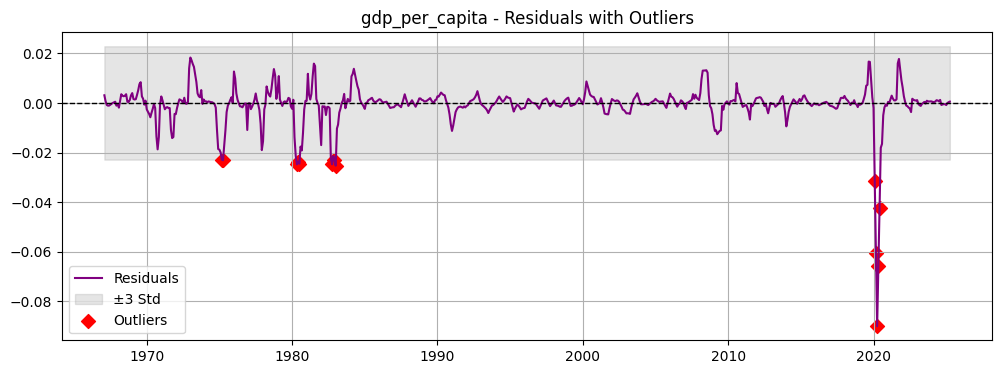

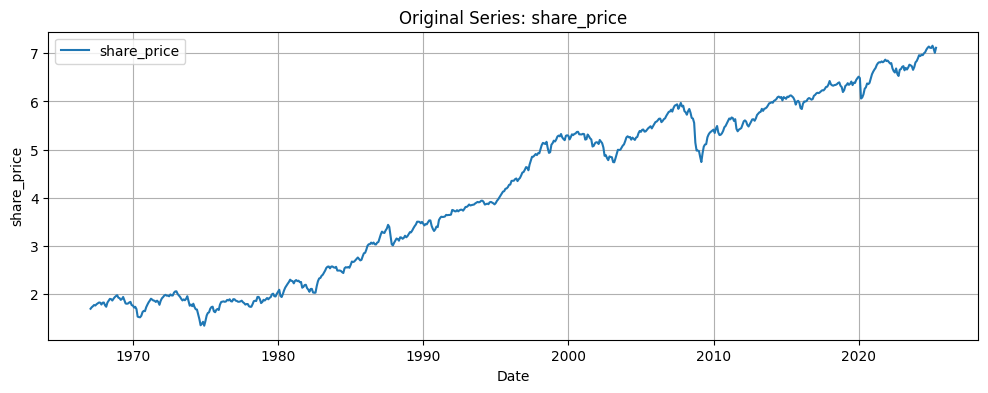

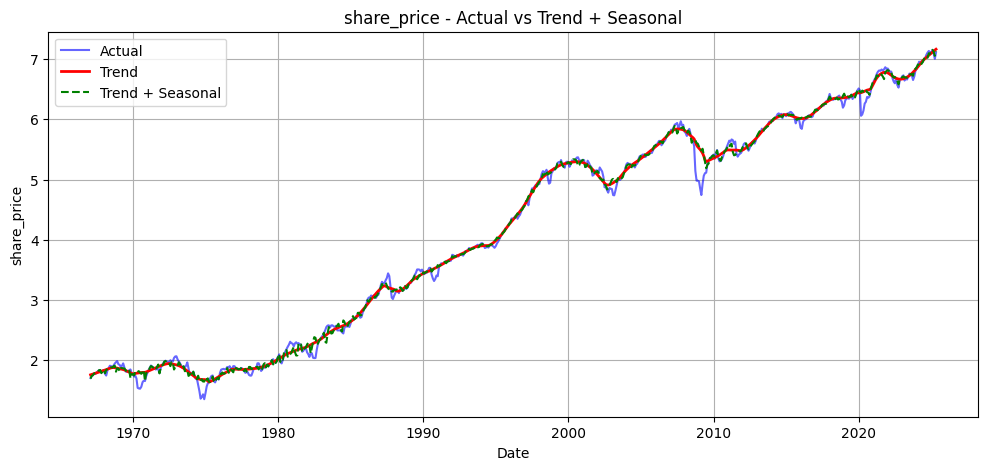

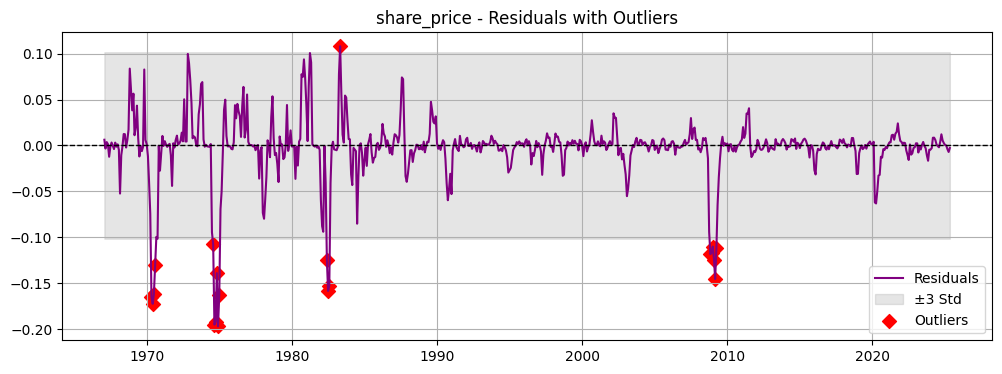

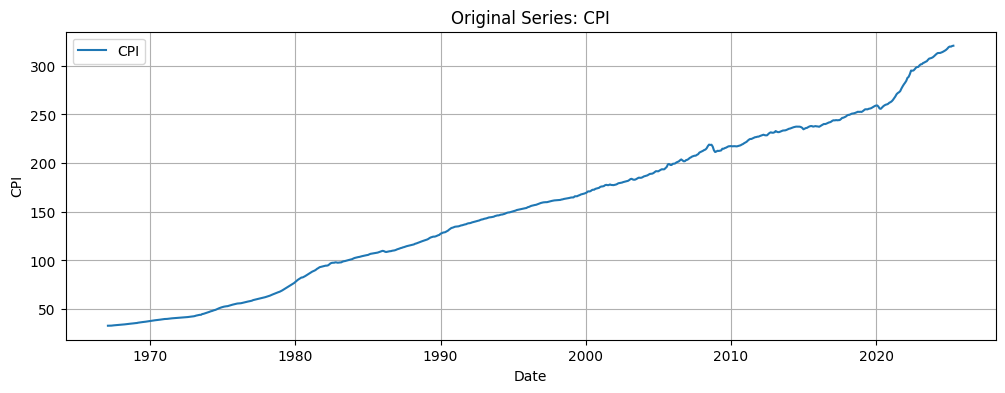

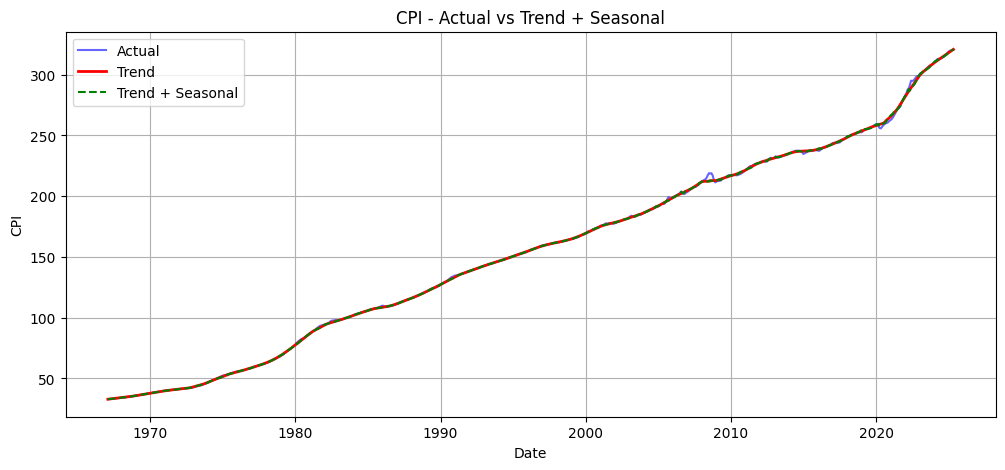

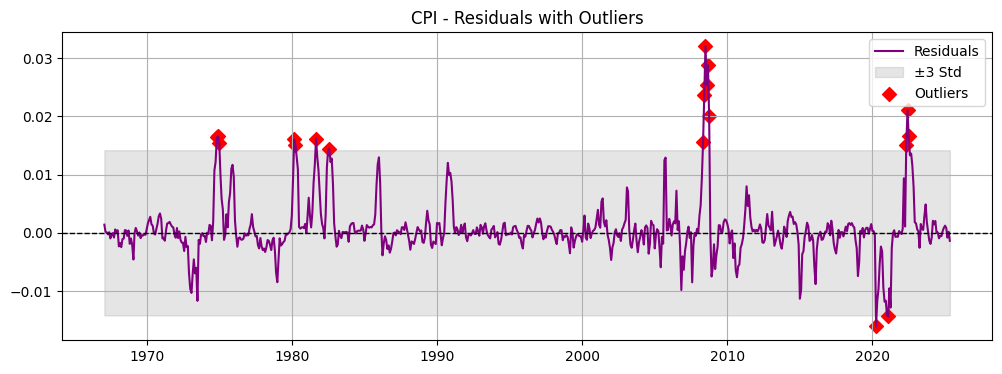

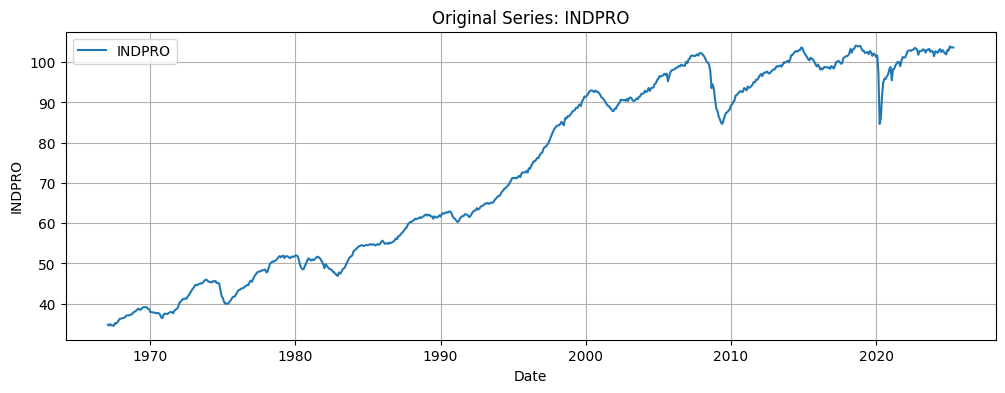

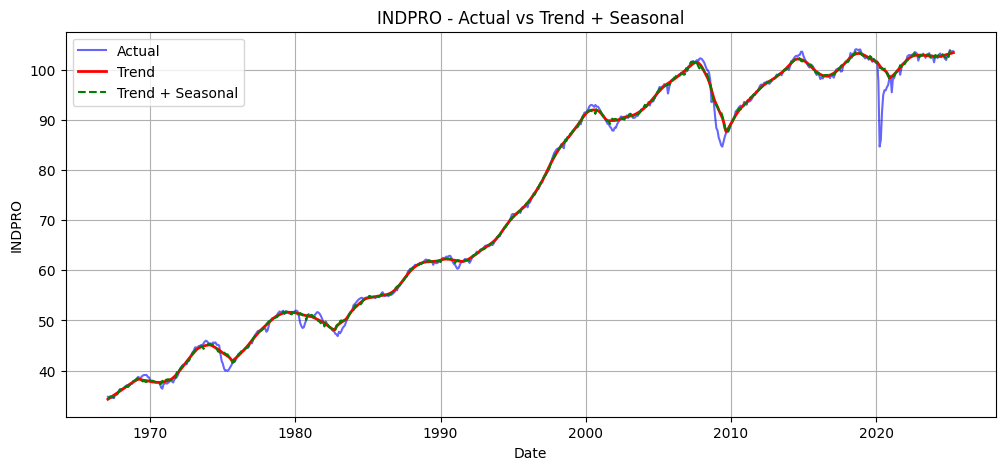

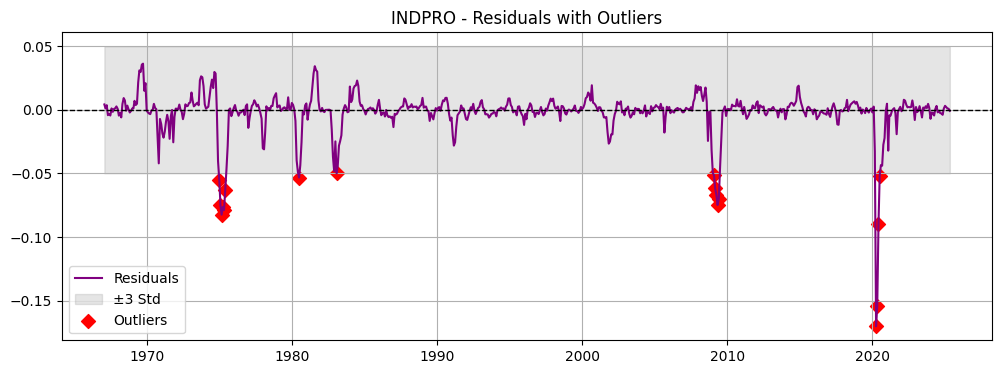

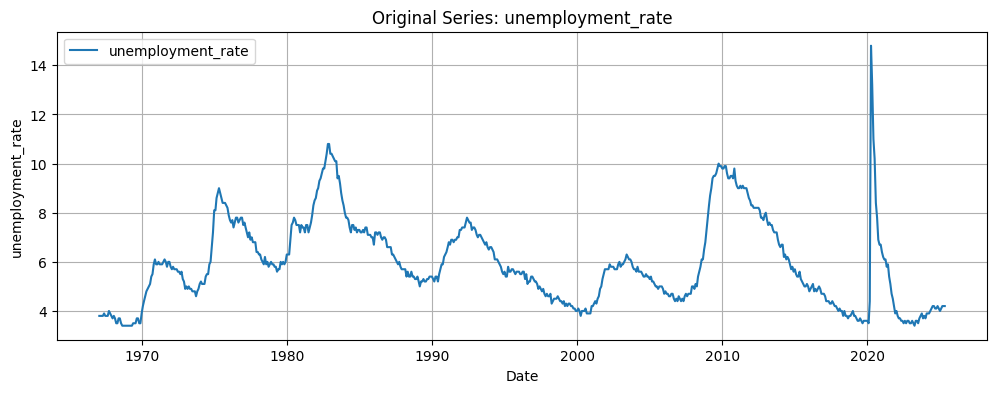

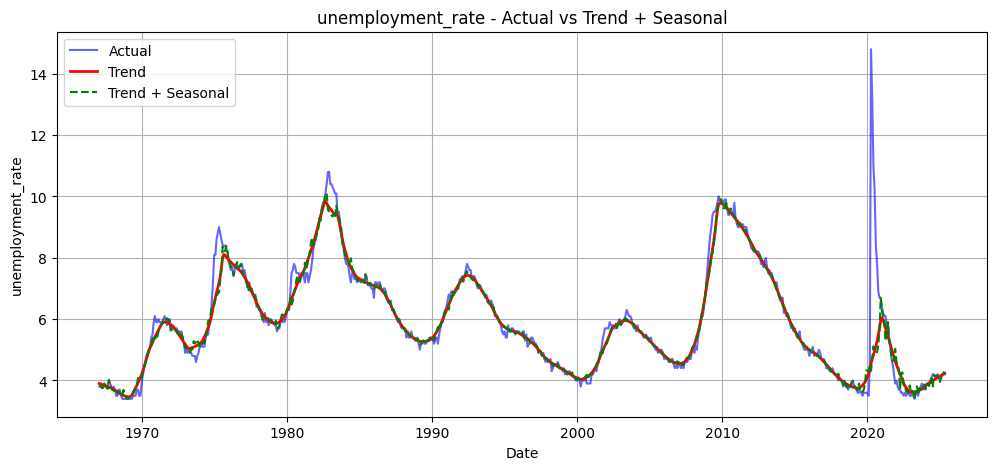

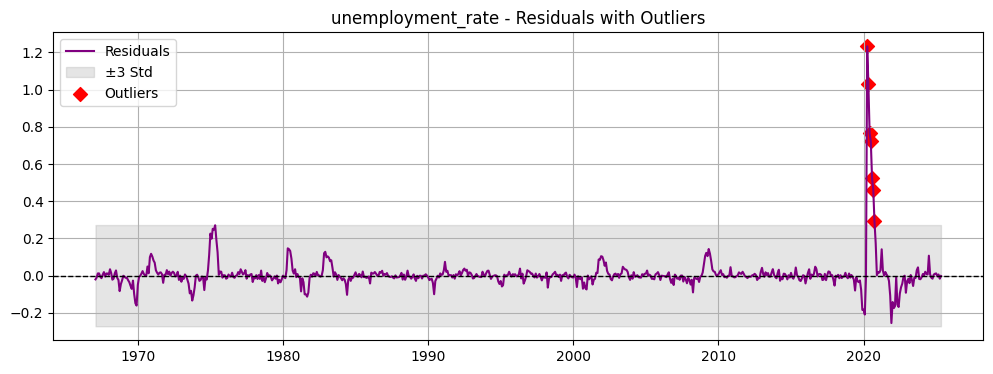

In [26]:
for col in cols_to_decompose:
    plt.figure(figsize=(12, 4))
    plt.plot(df.index, df[col], label=col)
    plt.title(f"Original Series: {col}")
    plt.xlabel("Date")
    plt.ylabel(col)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Perform multiplicative STL decomposition
    result, trend, seasonal, resid = multiplicative_stl(df[col])

    # Align index for plotting
    valid_index = df[col].replace(0, np.nan).dropna().index

    # ---------------------------
    # 1. Plot Actual + Trend + Seasonal
    # ---------------------------
    fig, ax1 = plt.subplots(figsize=(12, 5))
    ax1.plot(df.index, df[col], label='Actual', color='blue', alpha=0.6)
    ax1.plot(valid_index, trend, label='Trend', color='red', linewidth=2)
    ax1.plot(valid_index, seasonal * trend, label='Trend + Seasonal', color='green', linestyle='--')
    ax1.set_title(f"{col} - Actual vs Trend + Seasonal")
    ax1.set_xlabel("Date")
    ax1.set_ylabel(col)
    ax1.legend()
    ax1.grid(True)
    plt.show()

    # ---------------------------
    # 2. Plot Residuals with ±3 Std Bounds and Outliers
    # ---------------------------
    resid_log = result.resid
    resid_std = resid_log.std()
    upper_bound = 3 * resid_std
    lower_bound = -3 * resid_std

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(valid_index, resid_log, label='Residuals', color='purple')

    # Shade ±3 std area
    ax.fill_between(valid_index, lower_bound, upper_bound, color='gray', alpha=0.2, label='±3 Std')

    # Mark outliers
    outliers = (resid_log > upper_bound) | (resid_log < lower_bound)
    ax.scatter(valid_index[outliers], resid_log[outliers], 
               color='red', marker='D', s=50, label='Outliers')

    ax.axhline(0, color='black', linestyle='--', linewidth=1)
    ax.set_title(f"{col} - Residuals with Outliers")
    ax.legend()
    ax.grid(True)
    plt.show()


In [29]:
# Columns to seasonally adjust
cols_to_adjust = ['INDPRO', 'CPI', 'unemployment_rate']

for col in cols_to_adjust:
    # Drop NaNs for STL (make sure series is continuous)
    series = processed_recession_df[col].dropna()
    
    # Apply STL decomposition (additive, period=12 for monthly data)
    stl = STL(series, period=12, robust=True)
    result = stl.fit()
    
    # Seasonally adjusted = original - seasonal component
    seasonally_adjusted = series - result.seasonal
    
    # Add new column with seasonally adjusted data, align by index
    processed_recession_df[f'seasonally_adjusted_{col}'] = seasonally_adjusted

# Check the new columns
print(processed_recession_df[[*cols_to_adjust, 
                              'seasonally_adjusted_INDPRO', 
                              'seasonally_adjusted_CPI', 
                              'seasonally_adjusted_unemployment_rate']].head())

    INDPRO   CPI  unemployment_rate  seasonally_adjusted_INDPRO  \
0  34.7650  33.0                3.8                   34.423472   
1  34.5691  33.0                3.8                   34.446690   
2  34.8951  33.1                3.8                   34.755824   
3  34.5907  33.1                3.8                   34.680789   
4  34.5863  33.3                3.9                   34.726975   

   seasonally_adjusted_CPI  seasonally_adjusted_unemployment_rate  
0                32.920961                               3.795377  
1                32.974525                               3.834606  
2                33.085305                               3.903611  
3                33.182863                               3.887015  
4                33.305566                               3.812344  


In [30]:
processed_recession_df.columns

Index(['recession_probability', '1_month_recession_probability',
       '3_month_recession_probability', '6_month_recession_probability',
       '1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO',
       '10_year_rate', 'share_price', 'unemployment_rate', 'PPI',
       'OECD_CLI_index', 'CSI_index', 'Year', 'Quarter_Number', 'Month_Number',
       'date', 'gdp_per_capita', 'seasonally_adjusted_INDPRO',
       'seasonally_adjusted_CPI', 'seasonally_adjusted_unemployment_rate'],
      dtype='object')

In [31]:
# Columns to do anomaly detection on
cols_for_anomaly = [
    'INDPRO', 'CPI', 'unemployment_rate', 'PPI', 'share_price',
    '1_year_rate', '3_months_rate', '6_months_rate', '10_year_rate'
]

# Make sure your df is indexed by datetime
df = processed_recession_df.copy()
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

for col in cols_for_anomaly:
    # Drop zeros or negatives if any (for log in STL if multiplicative)
    series = df[col].replace(0, np.nan).dropna()
    
    # If too few data points, skip
    if len(series) < 24:  # arbitrary minimal length
        print(f"Skipping {col}, not enough data")
        continue

    # STL decomposition (additive)
    stl = STL(series, period=12, robust=True)
    result = stl.fit()
    
    resid = result.resid
    
    # Calculate residual std dev
    resid_std = resid.std()
    
    # Flag anomalies: 1 if abs(residual) > 3 * std, else 0
    anomaly_flag = (np.abs(resid) > 3 * resid_std).astype(int)
    
    # Align anomaly flags with main df index (may have dropped NaNs)
    anomaly_flag_full = pd.Series(data=0, index=df.index)
    anomaly_flag_full.loc[anomaly_flag.index] = anomaly_flag
    
    # Add new column
    df[f'anomaly_{col}'] = anomaly_flag_full

# Save or update your processed_recession_df
processed_recession_df = df.reset_index()
processed_recession_df.to_csv("../data/processed/recession_probability.csv", index=False)

print("Anomaly detection columns added successfully.")

Anomaly detection columns added successfully.


In [ ]:
processed_recession_df = pd.read_csv("../data/processed/recession_probability.csv")



In [ ]:
# Define columns and window sizes
cols_to_avg = ['share_price', 'CPI', 'INDPRO', 'unemployment_rate', 'PPI', 'gdp_per_capita']
windows = [1, 3, 6]  # months

for col in cols_to_avg:
    for w in windows:
        # Simple Moving Average
        processed_recession_df[f'{col}_sma_{w}'] = processed_recession_df[col].rolling(window=w).mean()
        # Exponential Moving Average
        processed_recession_df[f'{col}_ema_{w}'] = processed_recession_df[col].ewm(span=w, adjust=False).mean()


In [32]:
# Define columns and window sizes
cols_to_avg = ['share_price', 'CPI', 'INDPRO', 'unemployment_rate', 'PPI', 'gdp_per_capita']
windows = [1, 3, 6]  # months

for col in cols_to_avg:
    for w in windows:
        # Simple Moving Average
        processed_recession_df[f'{col}_sma_{w}'] = processed_recession_df[col].rolling(window=w).mean()
        # Exponential Moving Average
        processed_recession_df[f'{col}_ema_{w}'] = processed_recession_df[col].ewm(span=w, adjust=False).mean()

    # Trend gap features (SMA differences)
    processed_recession_df[f'{col}_gap_1_3'] = processed_recession_df[f'{col}_sma_1'] - processed_recession_df[f'{col}_sma_3']
    processed_recession_df[f'{col}_gap_1_6'] = processed_recession_df[f'{col}_sma_1'] - processed_recession_df[f'{col}_sma_6']
    processed_recession_df[f'{col}_gap_3_6'] = processed_recession_df[f'{col}_sma_3'] - processed_recession_df[f'{col}_sma_6']


In [33]:
processed_recession_df.columns

Index(['date', 'recession_probability', '1_month_recession_probability',
       '3_month_recession_probability', '6_month_recession_probability',
       '1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO',
       '10_year_rate', 'share_price', 'unemployment_rate', 'PPI',
       'OECD_CLI_index', 'CSI_index', 'Year', 'Quarter_Number', 'Month_Number',
       'gdp_per_capita', 'seasonally_adjusted_INDPRO',
       'seasonally_adjusted_CPI', 'seasonally_adjusted_unemployment_rate',
       'anomaly_INDPRO', 'anomaly_CPI', 'anomaly_unemployment_rate',
       'anomaly_PPI', 'anomaly_share_price', 'anomaly_1_year_rate',
       'anomaly_3_months_rate', 'anomaly_6_months_rate',
       'anomaly_10_year_rate', 'share_price_sma_1', 'share_price_ema_1',
       'share_price_sma_3', 'share_price_ema_3', 'share_price_sma_6',
       'share_price_ema_6', 'share_price_gap_1_3', 'share_price_gap_1_6',
       'share_price_gap_3_6', 'CPI_sma_1', 'CPI_ema_1', 'CPI_sma_3',
       'CPI_ema_3', 'CPI_

In [34]:
processed_recession_df['date'] = pd.to_datetime(processed_recession_df['date'])
processed_recession_df = processed_recession_df.set_index('date')

# 1️⃣ Drop redundant SMA/EMA columns except share_price momentum ones
cols_to_drop = [c for c in processed_recession_df.columns 
                if ('sma' in c or 'ema' in c) and not c.startswith('share_price')]
processed_recession_df = processed_recession_df.drop(columns=cols_to_drop)

# 2️⃣ STL helper function
def stl_features(series, period=12, anomaly_std=3):
    series_clean = series.replace(0, np.nan).dropna()
    series_log = np.log(series_clean)
    stl = STL(series_log, period=period, robust=True)
    res = stl.fit()

    # Reverse transform
    trend = np.exp(res.trend)
    seasonal = np.exp(res.seasonal)
    resid = np.exp(res.resid)

    # Seasonally adjusted = Original / Seasonal (multiplicative)
    seasonally_adjusted = series_clean / seasonal

    # Anomaly detection from residual
    resid_mean = res.resid.mean()
    resid_std = res.resid.std()
    anomaly_flag = (np.abs(res.resid - resid_mean) > anomaly_std * resid_std).astype(int)

    return trend, seasonally_adjusted, anomaly_flag

# 3️⃣ Columns to STL-decompose
cyclical_cols = ['CPI', 'INDPRO', 'unemployment_rate', 'PPI']

for col in cyclical_cols:
    trend, seas_adj, anomaly = stl_features(processed_recession_df[col])
    processed_recession_df[f'{col}_trend'] = trend
    processed_recession_df[f'seasonally_adjusted_{col}'] = seas_adj
    processed_recession_df[f'anomaly_{col}'] = anomaly

# 4️⃣ Reset index for saving
processed_recession_df = processed_recession_df.reset_index()

# # 5️⃣ Export to CSV
# processed_recession_df.to_csv("../data/processed/processed_recession_with_stl.csv", index=False)

# print("✅ STL features added, redundant columns dropped, file saved.")


In [36]:
processed_recession_df.columns

Index(['date', 'recession_probability', '1_month_recession_probability',
       '3_month_recession_probability', '6_month_recession_probability',
       '1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO',
       '10_year_rate', 'share_price', 'unemployment_rate', 'PPI',
       'OECD_CLI_index', 'CSI_index', 'Year', 'Quarter_Number', 'Month_Number',
       'gdp_per_capita', 'seasonally_adjusted_INDPRO',
       'seasonally_adjusted_CPI', 'seasonally_adjusted_unemployment_rate',
       'anomaly_INDPRO', 'anomaly_CPI', 'anomaly_unemployment_rate',
       'anomaly_PPI', 'anomaly_share_price', 'anomaly_1_year_rate',
       'anomaly_3_months_rate', 'anomaly_6_months_rate',
       'anomaly_10_year_rate', 'share_price_sma_1', 'share_price_ema_1',
       'share_price_sma_3', 'share_price_ema_3', 'share_price_sma_6',
       'share_price_ema_6', 'share_price_gap_1_3', 'share_price_gap_1_6',
       'share_price_gap_3_6', 'CPI_gap_1_3', 'CPI_gap_1_6', 'CPI_gap_3_6',
       'INDPRO_gap_

In [37]:
# Drop SMA, EMA, and gap columns
cols_to_drop = [c for c in processed_recession_df.columns 
                if '_sma_' in c or '_ema_' in c or '_gap_' in c]

processed_recession_df = processed_recession_df.drop(columns=cols_to_drop)

In [39]:
processed_recession_df.columns

Index(['date', 'recession_probability', '1_month_recession_probability',
       '3_month_recession_probability', '6_month_recession_probability',
       '1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO',
       '10_year_rate', 'share_price', 'unemployment_rate', 'PPI',
       'OECD_CLI_index', 'CSI_index', 'Year', 'Quarter_Number', 'Month_Number',
       'gdp_per_capita', 'seasonally_adjusted_INDPRO',
       'seasonally_adjusted_CPI', 'seasonally_adjusted_unemployment_rate',
       'anomaly_INDPRO', 'anomaly_CPI', 'anomaly_unemployment_rate',
       'anomaly_PPI', 'anomaly_share_price', 'anomaly_1_year_rate',
       'anomaly_3_months_rate', 'anomaly_6_months_rate',
       'anomaly_10_year_rate', 'CPI_trend', 'INDPRO_trend',
       'unemployment_rate_trend', 'PPI_trend', 'seasonally_adjusted_PPI'],
      dtype='object')

In [ ]:
processed_recession_df.to_csv("../data/processed/recession_probability.csv", index=False)
